In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Read dataset 
df = pd.read_csv("Dry_Bean_Dataset.csv")

# Separate features and target (assuming the target column is named 'Class')
X = df.drop("Class", axis=1)
y = df["Class"]

# Encode the target variable as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# fit gradient boosting classifier on training data
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

# Evaluate the model on the test set
y_test_pred = gb.predict(X_test)

print("\nTest Set Performance:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))
print("F1 Score (weighted):", f1_score(y_test, y_test_pred, average='weighted'))




Test Set Performance:
Confusion Matrix:
[[358   0  17   0   3   8  11]
 [  0 157   0   0   0   0   0]
 [ 15   0 457   0  11   2   4]
 [  0   0   0 978   1  12  73]
 [  1   0   6   6 557   0   8]
 [  0   0   0  11   0 582  15]
 [  2   0   0  94  13  11 671]]

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.90      0.93       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.95      0.93      0.94       489
    DERMASON       0.90      0.92      0.91      1064
       HOROZ       0.95      0.96      0.96       578
       SEKER       0.95      0.96      0.95       608
        SIRA       0.86      0.85      0.85       791

    accuracy                           0.92      4084
   macro avg       0.94      0.93      0.93      4084
weighted avg       0.92      0.92      0.92      4084

F1 Score (weighted): 0.9206095862376151


Original train class distribution: Counter({3: 2482, 6: 1845, 5: 1419, 4: 1350, 2: 1141, 0: 925, 1: 365})
entering find best hyperparameters
Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
Training Accuracy: 1.000
Test Accuracy: 0.921
Accuracy on the whole set: 0.976

Final Model Performance on Test Data:
Confusion Matrix:
[[364   0  16   0   3   8   6]
 [  0 157   0   0   0   0   0]
 [ 13   0 462   0  10   2   2]
 [  0   0   0 970   2  15  77]
 [  3   0   6   3 556   0  10]
 [  1   0   0  11   0 578  18]
 [  5   0   2  79  13  16 676]]

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.92      0.93       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.95      0.94      0.95       489
    DERMASON       0.91      0.91      0.91      1064
       HOROZ       0.95      0.96      0.96       578
       SEKER       0.93      0.95      0.94       608
        SIRA       0

C:\Users\angel\AppData\Local\Temp\ipykernel_20848\3224436410.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


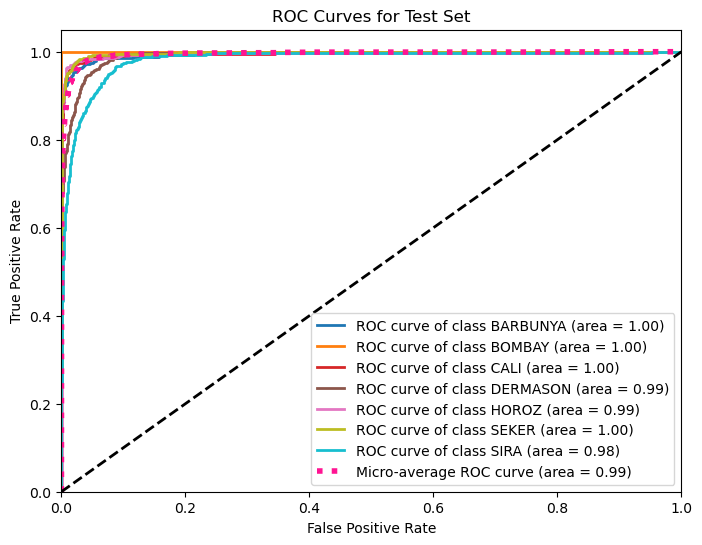

Average (macro) AUC: 0.994


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from collections import Counter
from imblearn.over_sampling import SMOTE

# Read dataset 
df = pd.read_csv("Dry_Bean_Dataset.csv")

# Separate features and target (assuming the target column is named 'Class')
X = df.drop("Class", axis=1)
y = df["Class"]

# Encode the target variable as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
orig_counts = Counter(y_train)
print("Original train class distribution:", orig_counts)


smote = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train_1, X_val, y_train_1, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5]
}

print("entering find best hyperparameters")
# Tune hyperparameters by performing GridSearchCV on the training set
grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    refit=True
)
grid.fit(X_train, y_train)
print("Best hyperparameters:", grid.best_params_)


# Retrain the model on the entire training set using the best hyperparameters
final_model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=grid.best_params_["n_estimators"],
    learning_rate=grid.best_params_["learning_rate"],
    max_depth=grid.best_params_["max_depth"]
)

final_model.fit(X_train, y_train)
# Evaluate the accuracy of the final model on the training set
y_train_pred = final_model.predict(X_train)
train_accuracy = np.mean(y_train_pred == y_train)
print(f"Training Accuracy: {train_accuracy:.3f}")
# Evaluate the accuracy of the final model on the test set
y_test_pred = final_model.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.3f}")
# Evaluate the accuracy of the final model on the whole set
y_pred = final_model.predict(X)
accuracy = np.mean(y_pred == y_encoded)
print(f"Accuracy on the whole set: {accuracy:.3f}")


# Evaluate the final model on test dataset
for name, X_eval, y_eval in [
    ("Test Data", X_test, y_test),
]:
    y_pred = final_model.predict(X_eval)
    print(f"\nFinal Model Performance on {name}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_eval, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_eval, y_pred, target_names=le.classes_))
    print("F1 Score (weighted):", f1_score(y_eval, y_pred, average='weighted'))
    # Binarize the output for multi-class ROC
    y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
    y_score = final_model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Test Set')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate macro-average AUC
    macro_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
    print(f"Average (macro) AUC: {macro_auc:.3f}")

In [4]:
y_test_pred = final_model.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.917
